<a href="https://colab.research.google.com/github/eshraongithub/DengAI-Predicting-Disease-Spread-ES/blob/main/2_DengAI_Predicting_Disease_Spread_Predicci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  El Problema

Predicción sobre los casos de dengue en una semana a partir de los datos metereológicos de la misma. La competición mide el error cometido en la predicción.
Vamos a utilizar los datos de la competición de predicción de los datos del Dengue. Mas información en [enlace](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

El objetivo del ejercicio es por un lado jugar con una red neuronal para resolver un problema de regresión y por otro participar en una competición de datos. 


# Setting preliminares y exploración de datos

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

# Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

En primer lugar subimos los datos de entrenamiento sin campo objetivo (**dengue_features_train**).

In [ ]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
train_feat.shape

(1456, 24)

Posteriormente subimos los datos que únicamente nos proporcionan el número de casos de dengue para las semanas de entrenamiento (**dengue_labels_train**).

In [ ]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Mezclamos los dos conjuntos de datos para tenerlos en un único dataframe

In [ ]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])

train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Finalmente subimos los datos del archivo **dengue_features_test** para generar la evaluación final.

In [ ]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


Exploramos los casos por ciudad usando un bloxplot y parece que existen observaciones que se pueden considerer outliers con casos de Dengue mayores a 70.

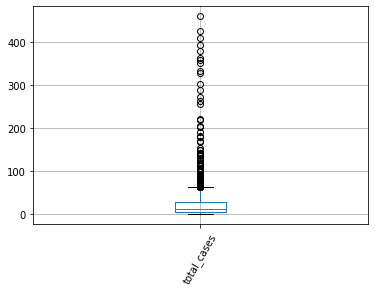

In [ ]:
# Creamos un bloxplot de casos por ciudad
train.boxplot('total_cases', rot=60)

# Mostramos el boxplot
plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

Comprobamos la varianza de las columnas en el conjunto de datos test.
Vemos 5 características en los datos de train con una varianza relativamente alta: *precipitation_amt_mm*, *reanalysis_precip_amt_kg_per_m2*, *reanalysis_sat_precip_amt_mm*, *station_precip_mm*, *total_cases*.

In [ ]:
train.var()

year                                       29.249860
weekofyear                                225.583493
ndvi_ne                                     0.019749
ndvi_nw                                     0.014400
ndvi_se                                     0.005455
ndvi_sw                                     0.007040
precipitation_amt_mm                     1911.048174
reanalysis_air_temp_k                       1.856187
reanalysis_avg_temp_k                       1.591925
reanalysis_dew_point_temp_k                 2.334203
reanalysis_max_air_temp_k                  10.462642
reanalysis_min_air_temp_k                   6.581093
reanalysis_precip_amt_kg_per_m2          1886.547008
reanalysis_relative_humidity_percent       51.178248
reanalysis_sat_precip_amt_mm             1911.048174
reanalysis_specific_humidity_g_per_kg       2.379289
reanalysis_tdtr_k                          12.577273
station_avg_temp_c                          1.670162
station_diur_temp_rng_c                     4.

Vemos 4 características en los datos de train con una varianza relativamente alta: *precipitation_amt_mm*, *reanalysis_precip_amt_kg_per_m2*, *reanalysis_sat_precip_amt_mm*, *station_precip_mm*.

In [ ]:
test.var()

year                                        2.058752
weekofyear                                224.348187
ndvi_ne                                     0.027012
ndvi_nw                                     0.020000
ndvi_se                                     0.006257
ndvi_sw                                     0.008469
precipitation_amt_mm                     1237.008095
reanalysis_air_temp_k                       2.159433
reanalysis_avg_temp_k                       1.706244
reanalysis_dew_point_temp_k                 2.319830
reanalysis_max_air_temp_k                   9.621266
reanalysis_min_air_temp_k                   7.623722
reanalysis_precip_amt_kg_per_m2          2392.140513
reanalysis_relative_humidity_percent       54.438464
reanalysis_sat_precip_amt_mm             1237.008095
reanalysis_specific_humidity_g_per_kg       2.426954
reanalysis_tdtr_k                          12.551927
station_avg_temp_c                          1.519322
station_diur_temp_rng_c                     6.

# Preproceso

Aquí incluimos todas las funciones y transformaciones que permitiran el uso de las variables en los siguientes pasos, por ejemplo la transformación de las variables categóricas en numéricas, etc.

In [ ]:
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)
train.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Trataremos los valores perdidos que los hay dado que nos evitarían tener un modelo de los datos que tenemos.

In [ ]:
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

Los vamos a procesar de forma automática completandolos con el método ffill (con el valor previo)

In [ ]:
# ffill: propagate last valid observation forward to next valid backfill
# Otra Opción: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

Y aplicamos lo mismo para los datos de test

In [ ]:
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

También tenemos que transformar nuestras variables categóricas, en este caso una única variable que es la ciudad para lo que vamos a utilizar un *binarizador* para train y para test

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

Vemos que después de transformar las ciudades en los dataframes de train y test, San Juan (sj) corresponde al número 1 y que Iquitos corresponde al número 0

In [ ]:
train

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,1
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5,0
1452,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8,0
1453,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1,0
1454,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1,0


In [ ]:
test

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,city_bin
0,sj,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,1
1,sj,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,1
2,sj,2008,20,-0.001500,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,1
3,sj,2008,21,-0.001500,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,1
4,sj,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0,0
412,iq,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0,0
413,iq,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2,0
414,iq,2013,25,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1,0


Quitamos la columna "city" en ambos dataframes

In [ ]:
train.drop("city", axis = 1, inplace = True)
test.drop("city", axis = 1, inplace = True)

## Selección de variables

Hay que seleccionar características, pueden ser todas, pero eso normalmente no es una buena idea, por lo que aquí dejaremos algunas seleccionadas tanto en los datos de train como en los datos de test.

In [ ]:
# Take a subset of the DataFrame that we want to scale 
train_selec_feat = train[['city_bin', 'reanalysis_dew_point_temp_k', 'total_cases']]
test_selec_feat = test[['city_bin', 'reanalysis_dew_point_temp_k']]

Revisamos la varianza de las características seleccionadas y notamos que total_cases tiene una varianza muy alta en comparación con el resto de características.

In [ ]:
train_selec_feat.var()

city_bin                          0.229750
reanalysis_dew_point_temp_k       2.333339
total_cases                    1900.611230
dtype: float64

In [ ]:
test_selec_feat.var()

city_bin                       0.234940
reanalysis_dew_point_temp_k    2.327153
dtype: float64

# k-NN

Vamos a probar un modelo k-NN aunque es más apropriado para probelmas de clasificación.
Entrenamos un modelo k-NN sobre los datos de train despuésa de implementar un split 70/30, para dividir el dataset de training en un conjunto de entrenamiento y otro de prueba, ajustar un modelo k-NN a los datos de entrenamiento con 15 vecions y luego calcular su precisión usando el método .score () y los datos de test obtenidos del split.
En este caso nos sale una precisión del 8% solo.

In [ ]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Create feature and target arrays
X = train_selec_feat.drop('total_cases', axis=1).values
y = train_selec_feat['total_cases'].values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create a k-NN classifier with 8 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=8)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.06407322654462243


Ahora calcularemos y mostraremos los niveles de precisión de entrenamiento y prueba para una variedad de valores vecinos diferentes. Al observar cómo difieren los niveles de precisión para los conjuntos de entrenamiento y prueba con diferentes valores de k, obtendremos una menor intuición sobre el overfitting y underfitting en este caso.
El gráfico nos muestra que un valor de k entre 10 y 15 generaría la mejor precisión en este caso.

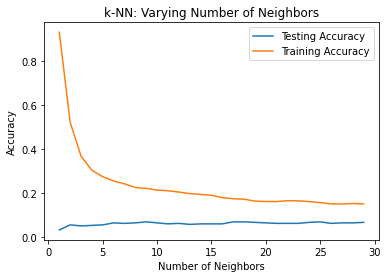

In [ ]:
# Creamos arrays para guardar precisiones de train y test
neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Empezamos un bucle sobre los diferentes valores de k
for i, k in enumerate(neighbors):
    # Creamos un clasificador k-NN con k número de vecinos: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Entrenamos el model k-NN sobre el conjunto de datos de training
    knn.fit(X_train, y_train)
    
    # Calculamos la precisión obre el conjunto de datos de training
    train_accuracy[i] = knn.score(X_train, y_train)

    # Calculamos la precisión sobre el conjunto de datos de test
    test_accuracy[i] = knn.score(X_test, y_test)

# Generamos un gráfico
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
prediction = knn.predict(test_selec_feat)
print("Prediction: {}".format(prediction))

Prediction: [ 3  5  3  5  7  3 10  6 20 29  2 18  5 20  4 14  6  4  4  4  4  5  7 20
 20  6  4 29  6 10  2 20  3 17  9  9  9 17  2  3  8 17  4 20 17  4  2  4
  2  9 17 14 17 14 10  2 14 10 10 20 10 13 29  6  6  4  5  6  6 27  3 14
 10 14  4  4  4 14  6  5  2 20 29  4  4  4  2  2  2  5  3  1  6  3  5  5
  2  3  5  6  1  3 14 26  3 29  5 20 29 10  4 27  4  4 10 10  4  4  4  4
  4  4  4  4  4 18 14  4  4  6  6  6 29 12 14 17  0  2  8  3  9  3  3  8
 14  8  6 17  2 20  0  4 17  2  3  8 14  3  3  3 14  6  6 10 10  4  4  4
  6 10 18 10  4 10  4  6  4  6  4  4  5 20 10 12 20 20  2 10  7  3  9  3
  8  7 14 17  9 14 14 17  3 14  3  9 14 12  3  5 17  4 26 14 13 26 14 20
  5  6  5  3  6  4  6  4  4  4  6  5 20 14  6  6 20  4  6 14 29 20  5 10
  3  5 17 12 17  6 17 17 17  6  9 17 33  2  0 12  3  1 12  3  5  0  6  0
  0  1  0  0  0  1  0  0  0  0  0  1  2  5  2  2  0  2  0  2  6  0  1  0
  1  1  0  0  2  0  5  5  2  2  5  5  4  2  2  5  2  0  0  1  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  1  1

## Regresión lineal con validación cruzada

Teniendo en cuenta que la variable a predecir (target) es cuantitativa, este es un problema de regresión. Por lo tanto, vamos a desarrollar un modelo de regresión lineal.

In [ ]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Create feature and target arrays
X = train_selec_feat.drop('total_cases', axis=1).values
y = train_selec_feat['total_cases'].values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=10)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

[-0.11198443 -0.08211309  0.06021644 -0.13687205 -1.17413936 -0.40023748
  0.41390434 -0.57766252 -0.15947179 -0.07855719]
Average 10-Fold CV Score: -0.2246917124503514
R^2: 0.11911187252119015
Root Mean Squared Error: 46.60443594899266


Nuestro modelo de Lasso actual tiene una puntuación R2 de 18,4%. Cuando un modelo aplica una regularización demasiada alta, puede sufrir un alto sesgo, lo que perjudica su poder predictivo.

Mejoremos el equilibrio entre el poder predictivo y la simplicidad del modelo ajustando el parámetro alpha.

Probamos diferentes valores de alpha que dé el valor R2 más alto de las opciones: 1, 0.5, 0.1 y 0.01.
Vemos que el valor alpha 0.01 da el R2 más alto mientras ignora solo 2 de las 23 características.

Trabajamos la regresión de nuevo, esta vez después de escalar los datos y después de optimizar nuestro l1_ratio de ElasticNet usando GridSearchCV.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('elasticnet', ElasticNet())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Create train and test sets
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
gm_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642173.4551857379, tolerance: 135.09304368098157
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569597.350167834, tolerance: 120.18168220858905
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604551.6628311822, tolerance: 127.94029325153375
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687830.961

Tuned ElasticNet Alpha: {'elasticnet__l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.11204751695656301


Realizamos la predicción sobre los datos de test usando el GridSearchCV y calculamos el RMSE.

In [ ]:
y_pred_pipeline = gm_cv.predict(X_test)
# Compute and print RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_pipeline))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 46.790936854891534


### Regularización Ridge (L2)

Creamos una función para mostrar en gráficos el coeficiente de determinación.

In [ ]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

Probamos y evaluamos la regresión Ridge.

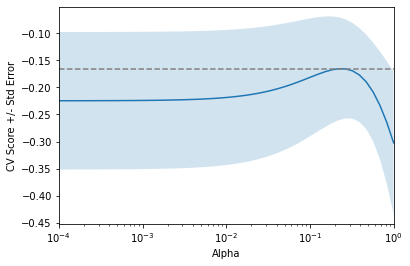

In [ ]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [ ]:
ridge = Ridge(alpha=0.5, normalize=True).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

In [ ]:
ridge.score(X_test, y_test)

0.09106165271715738

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 47.34063629898738


# Lasso Regression

Primero estandarizaremos los datos utilizando StandardScaler () como escalador para asegurarse de que todos los coeficientes se enfrenten a una fuerza de regularización comparable y tratar de reducirlos.
Después de entrenar el modelo Lasso, puntuaremos su capacidad predictiva (R2) sobre el conjunto de test y contaremos cuántas características se ignoran porque su coeficiente se reduce a cero.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Create feature and target arrays
X = train.drop('total_cases', axis=1).values
y = train['total_cases'].values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Create the Lasso model
la = Lasso()

# Fit it to the standardized training data
la.fit(X_train_std, y_train)

print(la.coef_)

# Transform the test set with the pre-fitted scaler
X_test_std = scaler.transform(X_test)

# Calculate the coefficient of determination (R squared) on X_test_std
r_squared = la.score(X_test_std, y_test)
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))

# Create a list that has True values when coefficients equal 0
zero_coef = la.coef_ == 0

# Calculate how many features have a zero coefficient
n_ignored = sum(zero_coef)
print("The model has ignored {} out of {} features.".format(n_ignored, len(la.coef_)))

[-8.53899991  5.58673275 -0.79784208 -0.         -6.06868025  4.07627092
  0.          1.85690436  0.          0.         -0.          1.56830379
  0.         -0.          0.          1.56067322 -3.8096461   0.
 -0.          0.          0.          0.          0.        ]
The model can predict 18.4% of the variance in the test set.
The model has ignored 14 out of 23 features.


In [ ]:
# Find the highest alpha value with R-squared above 19%
la = Lasso(alpha=0.5, random_state=0)

# Fits the model and calculates performance stats
la.fit(X_train_std, y_train)
r_squared = la.score(X_test_std, y_test)
n_ignored_features = sum(la.coef_ == 0)

# Predict on the test data: y_pred
y_pred = la.predict(X_test_std)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))

# Print peformance stats 
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))
print("{} out of {} features were ignored.".format(n_ignored_features, len(la.coef_)))
print("Root Mean Squared Error: {}".format(rmse_lasso))

The model can predict 19.4% of the variance in the test set.
13 out of 23 features were ignored.
Root Mean Squared Error: 44.58472748916173


Calculamos el valor óptimo alpha del LassoCV regressor.
Vemos que obtenemos un valor R2 más alto y que hemos quitados 13 caracteristicas.

In [ ]:
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train_std, y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test_std, y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

# Predict on the test data: y_pred
y_pred = lcv.predict(X_test_std)

rmse_lcv = np.sqrt(mean_squared_error(y_test, y_pred))

# Print peformance RMSE 
print("Root Mean Squared Error: {}".format(rmse_lcv))

Optimal alpha = 0.421
The model explains 19.5% of the test set variance
10 features out of 23 selected
Root Mean Squared Error: 44.55792971698672


### Modelos ensemble para conseguir votos extra sobre las características que consideran más importantes.

El modelo LassoCV () seleccionó 10 de 32 características. Lo que tampoco es una reducción espectacular de dimensionalidad. Usaremos dos modelos más para seleccionar las 10 características que consideren más importantes usando el Recursive Feature Eliminator (RFE).

Seleccionamos 10 funciones con RFE en un GradientBoostingRegressor y quitamos 3 características en cada paso.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=3, verbose=1)
rfe_gb.fit(X_train_std, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test_std, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 23 features.
Fitting estimator with 20 features.
Fitting estimator with 17 features.
Fitting estimator with 14 features.
Fitting estimator with 11 features.
The model can explain 66.8% of the variance in the test set


Seleccionamos 10 características con RFE y un RandomForestRegressor () y quitando 3 características en cada paso.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=10, step=3, verbose=1)
rfe_rf.fit(X_train_std, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test_std, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

Fitting estimator with 23 features.
Fitting estimator with 20 features.
Fitting estimator with 17 features.
Fitting estimator with 14 features.
Fitting estimator with 11 features.
The model can explain 72.3% of the variance in the test set


Incluyendo el modelo lineal Lasso del paso anterior, ahora tenemos los votos de 3 modelos en los que las características son importantes.

### Combinamos 3 selectores de características

Combinaremos los votos de los 3 modelos que hemos construido en los pasos anteriores para decidir qué características son importantes en un meta mask. Luego usaremos esta mask para reducir la dimensionalidad y veremos cómo funciona un regresor lineal simple en el conjunto de datos reducido.

Sumamos los votos de los 3 modelos.

In [ ]:
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)
print(votes)

[3 3 1 0 3 3 0 3 0 2 0 2 1 1 0 3 1 1 0 1 0 2 0]


Creamos un mask para las características seleccionadas por los 3 modelos.

In [ ]:
# Create a mask for features selected by all 3 models
meta_mask = votes >= 3
print(meta_mask)

[ True  True False False  True  True False  True False False False False
 False False False  True False False False False False False False]


Aplicamos la reducción de dimensionalidad sobre X e imprimimos qué características fueron seleccionadas.

Redefinimos las variables X y y.

In [ ]:
# Create feature and target
X = train.drop('total_cases', axis=1)
y = train['total_cases']

In [ ]:
# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]
print(X_reduced.columns)

Index(['year', 'weekofyear', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_specific_humidity_g_per_kg'],
      dtype='object')


Conectamos el conjunto de datos reducido al modelo de regresión lineal simple.

In [ ]:
# Plug the reduced dataset into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Create the regressor again: reg
reg_ensemble = LinearRegression()

# Fit it to the standardized training data
reg_ensemble.fit(X_train_std, y_train)

# Transform the test set with the pre-fitted scaler
X_test_std = scaler.transform(X_test)

# Calculate the coefficient of determination (R squared) on X_test_std
r_squared = reg_ensemble.score(X_test_std, y_test)

# Predict on the test data: y_pred
y_pred = reg_ensemble.predict(X_test_std)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_ensemble.score(X_test_std, y_test)))
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(reg_ensemble.coef_)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.17258379315567995
The model can explain 17.3% of the variance in the test set using 6 features.
Root Mean Squared Error: 37.88337701923014


Usando los votos de 3 modelos pudimos seleccionar solo 6 características que nos permitieron aumentar la precisión del modelo lineal simple.

## Regression tree

Vamos a entrenar un árbol de regresión para predecir el número de casos en base a las 6 características seleccionadas por los modelos ensemble.

In [ ]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Plug the reduced dataset into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=4,
             min_samples_leaf=0.13,
            random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.13, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=3, splitter='best')

Evaluaremos el rendimiento del conjunto de datos de prueba de dt utilizando la métrica de error cuadrático medio (RMSE). El RMSE de un modelo mide, en promedio, cuánto difieren las predicciones del modelo de las etiquetas reales. El RMSE de un modelo se puede obtener calculando la raíz cuadrada del error cuadrático medio (MSE) del modelo.

In [ ]:
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set Root Mean Squared Error of the Decision Tree: {:.2f}".format(rmse_dt))

Test set Root Mean Squared Error of the Decision Tree: 35.56


Evaluar el error cuadrático medio (RMSE) con CV=10 logrado por el árbol de regresión *dt* que hemos entrenado en el paso anterior. CV es una técnica muy útil para obtener una estimación del rendimiento de un modelo sin afectar el conjunto de datos de prueba.

In [ ]:
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 39.09


Evaluaremos el RMSE del conjunto de datos de entrenamiento logrado por el árbol de regresión dt y vemos que el error RMSE de entrenamiento es aproximadamente igual al error con CV=10 que obtuvimos en el paso anterior.

In [ ]:
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 38.23


# Random Forest regressor

Usaremos un algoritmo de random forests. Como primer paso, definirá un regresor de random forests y lo entrenaremos al conjunto de entrenamiento.

In [ ]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Create feature and target arrays
X = train.drop('total_cases', axis=1)
y = train['total_cases']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

En el siguiente paso obtendremos la evaluación RMSE utilizando el conjunto de datos de prueba para evaluar el regressor random forest.

In [ ]:
# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 30.85


El RMSE conseguido usando el random forest es significativamente más bajo que el logrado por un decision tree.

En el siguiente paso, determinaremos qué características fueron las más predictivas según el regresor de random forest "rf" que hemos entrenado. Para ello, vamos a mostrar un diagrama de barras horizontal de la importancia de las características según la evaluación de "rf". Afortunadamente, esto se puede hacer fácilmente gracias a las capacidades de visualización de pandas. Creamos un objeto pandas.Series llamado importances que contiene los nombres de las características como índice y sus importancias como valores.

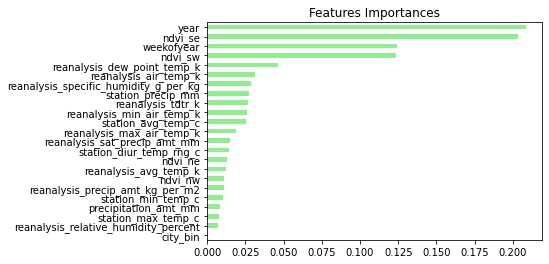

In [ ]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_, index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

Vemos que "year", "ndvi_se", "weekofyear" y "ndvi_sw" son las características más importantes según rf. La importancia de esas cuatro características suman más del 60%.

***Hasta ahora el mejor MAE que hemos conseguido sobre la predicción final (MAE de 26.8) ha sido usando el modelo de regresión lineal y sin escalar los datos, y por lo tanto, es el que vamos a usar en esta actividad para obtener la predicción final.***

# Predicción final

Guardamos las caracteristicas seleccionadas un dataframe "voted_feat"

In [ ]:
voted_feat = ['year', 'weekofyear', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_specific_humidity_g_per_kg']

Seleccionamos solo las caracteristicas seleccionadas para el conjunto de test de la predicción final.

In [ ]:
test_voted_feat = test[voted_feat]

Generamos la predicción final usando el model de regresión lineal sobre los datos de test del concurso usando solo las caracteristicas seleccionadas.

In [ ]:
final_pred = reg.predict(test_selec_feat)

La siguiente tarea es evaluar el rendimiento del modelo. Vamos a buscar  métricas disponibles en scikit-learn que le permitirán evaluar el desempeño de su modelo de una manera más matizada.

* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(final_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res.shape

(416,)

In [ ]:
test.shape

(416, 23)

Volvemos a nombrar las ciudades en el dataset de "test"

In [ ]:
test["city_bin"].replace({1: "sj", 0: "iq"}, inplace=True)

* Generamos el fichero de salida

In [ ]:
# generate output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,30
1,sj,2008,19,29
2,sj,2008,20,33
3,sj,2008,21,29
4,sj,2008,22,31


**Se adjunta junto a este notebook un pantallazo mostrando el usuario de DrivenData utilizado y los resultados obtenidos.**